In [1]:
import pandas as pd
from equipment.vdi.zbd import ZBD
from kid_readout.analysis import dataframe

In [2]:
def zbd_peak_voltage(lockin_rms_voltage):
    return 2**(-1/2) * np.pi * lockin_rms_voltage

def lockin_rms_voltage(zbd_peak_voltage):
    return 2**(1/2) / np.pi * zbd_peak_voltage

def zbd_power(lockin_rms_voltage, optical_frequency=None):
    if optical_frequency is None:
        return zbd_peak_voltage(lockin_rms_voltage) / 2200
    else:
        return zbd_peak_voltage(lockin_rms_voltage) / ZBD().responsivity(optical_frequency)

In [6]:
def rectangle(df, H1, L1, H2, L2):
    mask_H1 = df.mickey == H1
    mask_L1 = df.mickey == L1
    mask_H2 = df.minnie == H2
    mask_L2 = df.minnie == L2
    HH = df[mask_H1 & mask_H2]
    HL = df[mask_H1 & mask_L2]
    LH = df[mask_L1 & mask_H2]
    LL = df[mask_L1 & mask_L2]
    return HH, HL, LH, LL

def extract_all(rectangle, key='zbd_power'):
    extracted = []
    for HH, HL, LH, LL in rectangle:
        for dummy, row_HH in HH.iterrows():
            for dummy, row_HL in HL.iterrows():
                for dummy, row_LH in LH.iterrows():
                    for dummy, row_LL in LL.iterrows():
                        extracted.append((row_HH[key], row_HL[key],
                                          row_LH[key], row_LL[key],
                                          ((row_HH[key] * row_LL[key]) /
                                           (row_HL[key] * row_LH[key]))))
    return extracted

def plot_rectangles(rectangles):
    fig, ax = plt.subplots()
    for HH, HL, LH, LL, linearity in rectangles:
        ax.plot(sorted([1e6 * HH, 1e6 * HL, 1e6 * LH, 1e6 * LL]),
                4 * [linearity],
                '.-k', alpha=0.5)
    ax.set_xlabel('ZBD power [$\mu$W]')
    ax.set_ylabel('linearity')
    return fig, ax

In [7]:
optical_frequency = 156e9
df_filename = '/home/flanigan/equipment/vdi/calibration_156_GHz.npy'
df = pd.DataFrame().from_records(np.load(df_filename))

In [8]:
df.sort('time', inplace=True)
mickey_witness = 6
minnie_witness = 6
witness = df[(df.mickey==mickey_witness) & (df.minnie==minnie_witness)]
first = witness[witness.time==witness.time.min()]
df['R_compensated'] = df.R / np.interp(df.time, witness.time, witness.R / first.iloc[0].R)

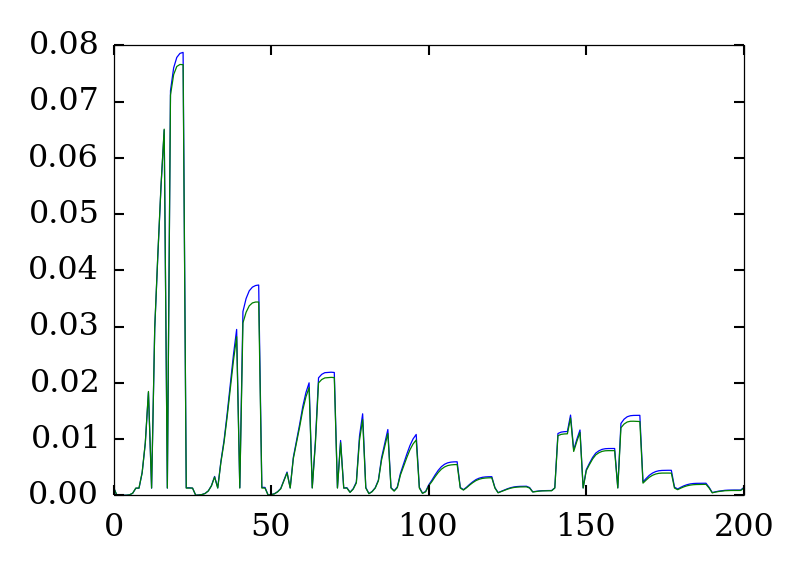

In [9]:
plt.plot(df.R)
plt.plot(df.R_compensated);

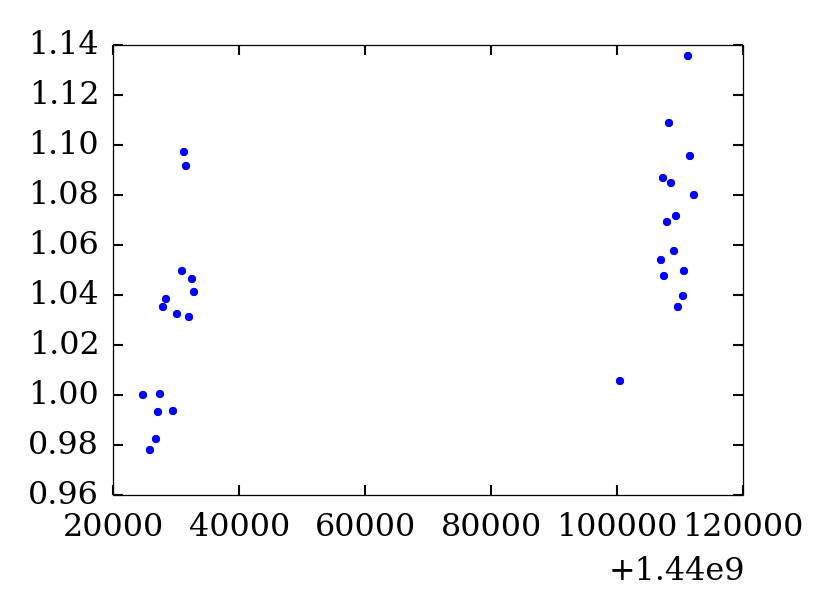

In [10]:
plt.plot(witness.time, witness.R / first.iloc[0].R, '.')

In [71]:
df['zbd_power_raw'] = zbd_power(df.R, optical_frequency)
df['zbd_power'] = zbd_power(df.R_compensated, optical_frequency)

minimum_linear_power = 1e-6
maximum_linear_power = 10e-6
df['is_linear'] =  ((df.zbd_power >= minimum_linear_power) &
                    (df.zbd_power <= maximum_linear_power))
df['is_linear_raw'] =  ((df.zbd_power_raw >= minimum_linear_power) &
                        (df.zbd_power_raw <= maximum_linear_power))

df['is_low'] = df.zbd_power < minimum_linear_power
df['is_high'] = df.zbd_power > maximum_linear_power

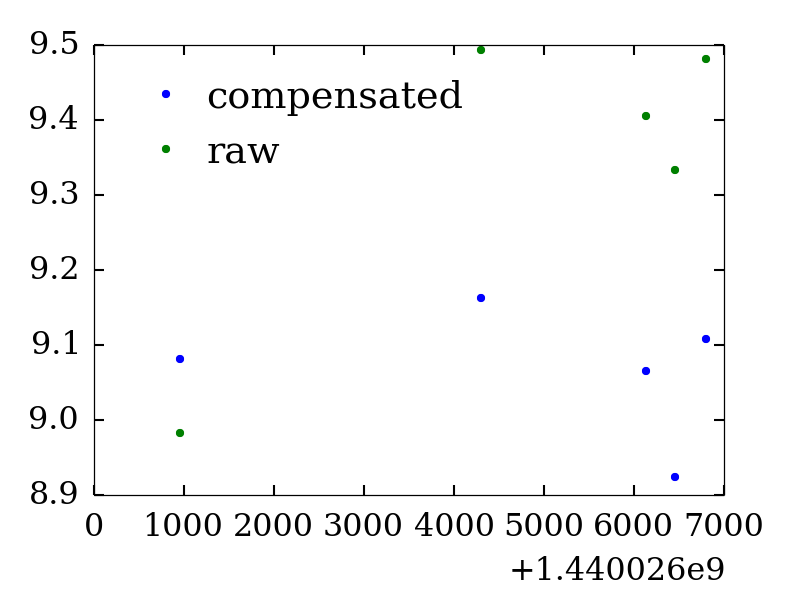

In [53]:
#plt.semilogy(df[(df.mickey==6) & (df.minnie==6)].time,
#         df[(df.mickey==6) & (df.minnie==6)].zbd_power,
#        '.')
plt.plot(df[(df.mickey==5) & (df.minnie==5)].time,
         1e6 * df[(df.mickey==5) & (df.minnie==5)].zbd_power,
        '.', label='compensated')

plt.plot(df[(df.mickey==5) & (df.minnie==5)].time,
         1e6 * df[(df.mickey==5) & (df.minnie==5)].zbd_power_raw,
        '.', label='raw')
plt.legend(loc='best');

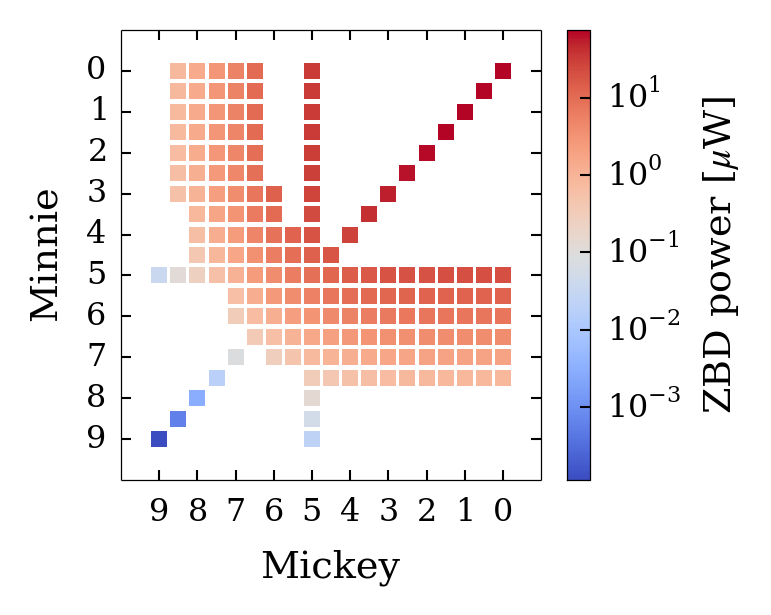

In [54]:
fig, ax = plt.subplots(figsize=(2.5, 2))
data = 1e6 * df.zbd_power
norm = matplotlib.colors.LogNorm
mappable = plt.cm.ScalarMappable(norm(min(data), max(data)), cmap=plt.cm.coolwarm)
mappable.set_array(np.array(data))
for n, row in df.iterrows():
    ax.plot(row.mickey, row.minnie, color=mappable.to_rgba(1e6 * row.zbd_power),
            marker='s', markersize=4, markeredgecolor='none')
ax.set_xlim(10, -1)
ax.set_xticks(range(9, -1, -1))
ax.set_ylim(10, -1)
ax.set_yticks(range(9, -1, -1))
ax.set_xlabel('Mickey')
ax.set_ylabel('Minnie')
fig.colorbar(mappable, label=r'ZBD power [$\mu$W]');

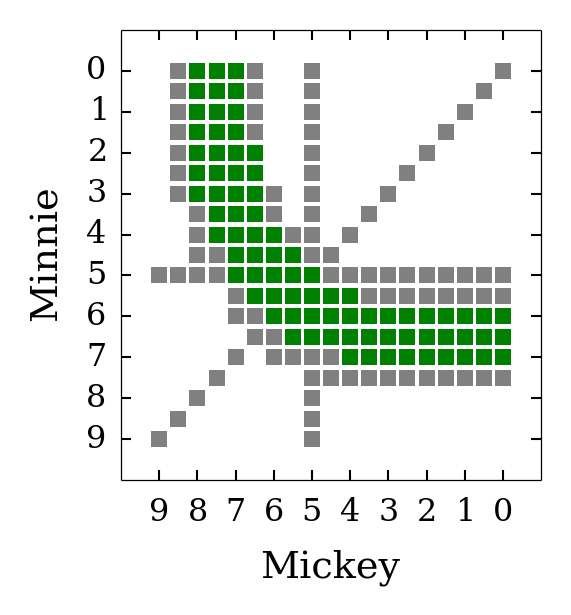

In [55]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(df.mickey[df.is_linear], df.minnie[df.is_linear],
        color='green', marker='s', markersize=4, markeredgecolor='none', linestyle='none')
ax.plot(df.mickey[~df.is_linear], df.minnie[~df.is_linear],
        color='gray', marker='s', markersize=4, markeredgecolor='none', linestyle='none')
ax.set_xlim(10, -1)
ax.set_xticks(range(9, -1, -1))
ax.set_ylim(10, -1)
ax.set_yticks(range(9, -1, -1))
ax.set_xlabel('Mickey')
ax.set_ylabel('Minnie');

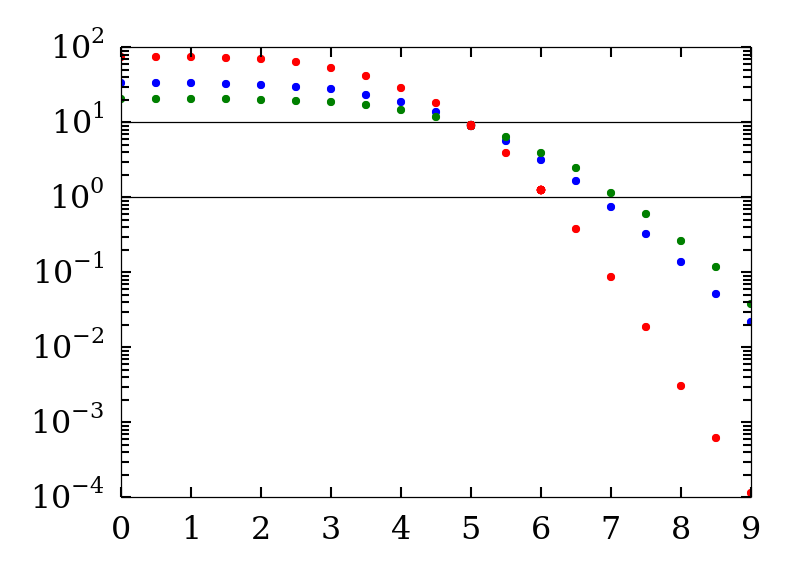

In [56]:
fig, ax = plt.subplots()
ax.axhline(1, color='k')
ax.axhline(10, color='k')
ax.semilogy(df[df.mickey==5].minnie, 1e6 * df[df.mickey==5].zbd_power, '.')
ax.semilogy(df[df.minnie==5].mickey, 1e6 * df[df.minnie==5].zbd_power, '.')
ax.semilogy(df[df.minnie==df.mickey].mickey, 1e6 * df[df.minnie==df.mickey].zbd_power, '.');

# Look at the effect of compensation

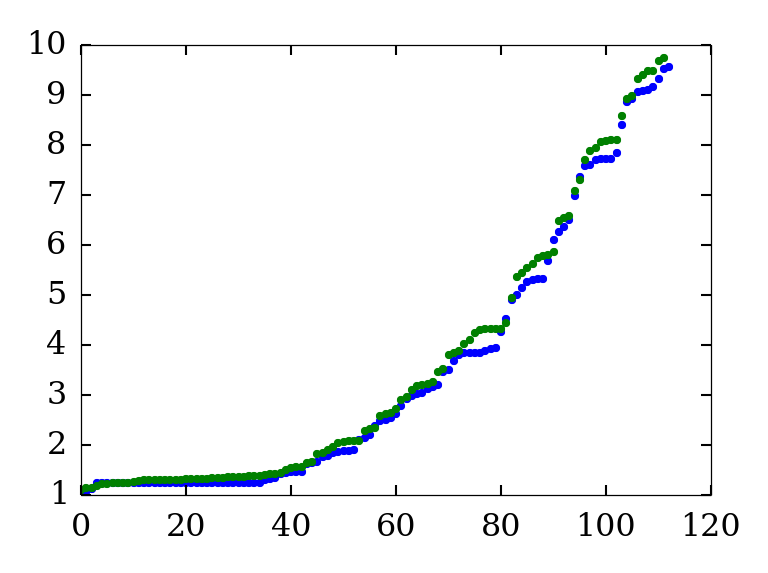

In [72]:
plt.plot(sorted(1e6 * df[df.is_linear].zbd_power), '.')
plt.plot(sorted(1e6 * df[df.is_linear_raw].zbd_power_raw), '.')

In [115]:
linear_rectangles = []
max1 = 0
max2 = 0
min1 = df[df.is_linear].mickey.max()
min2 = df[df.is_linear].minnie.max()
for H1 in np.arange(2 * max1, 2 * min1) / 2:
    for L1 in np.arange(2 * H1 + 1, 2 * min1 + 1) / 2:
        for H2 in np.arange(2 * max2, 2 * min2) / 2:
            for L2 in np.arange(2 * H2 + 1, 2 * min2 + 1) / 2:
                HH, HL, LH, LL = rectangle(df[df.is_linear], H1, L1, H2, L2)
                if not HH.empty and not HL.empty and not LH.empty and not LL.empty:
                    linear_rectangles.append((HH.iloc[0].zbd_power,
                                              HL.iloc[0].zbd_power,
                                              LH.iloc[0].zbd_power,
                                              LL.iloc[0].zbd_power,
                                              ((HH.iloc[0].zbd_power * LL.iloc[0].zbd_power) /
                                               (HL.iloc[0].zbd_power * LH.iloc[0].zbd_power))))

In [116]:
linear_rectangles_raw = []
max1 = 0
max2 = 0
min1 = linear_raw.mickey.max()
min2 = linear_raw.minnie.max()
for H1 in np.arange(2 * max1, 2 * min1) / 2:
    for L1 in np.arange(2 * H1 + 1, 2 * min1 + 1) / 2:
        for H2 in np.arange(2 * max2, 2 * min2) / 2:
            for L2 in np.arange(2 * H2 + 1, 2 * min2 + 1) / 2:
                HH, HL, LH, LL = rectangle(linear_raw, H1, L1, H2, L2)
                if not HH.empty and not HL.empty and not LH.empty and not LL.empty:
                    linear_rectangles_raw.append((HH.iloc[0].zbd_power,
                                              HH.iloc[0].zbd_power,
                                              LH.iloc[0].zbd_power,
                                              LL.iloc[0].zbd_power,
                                              ((HH.iloc[0].zbd_power * LL.iloc[0].zbd_power) /
                                               (HL.iloc[0].zbd_power * LH.iloc[0].zbd_power))))

In [117]:
len(linear_rectangles)

290

In [118]:
len(linear_rectangles_raw)

291

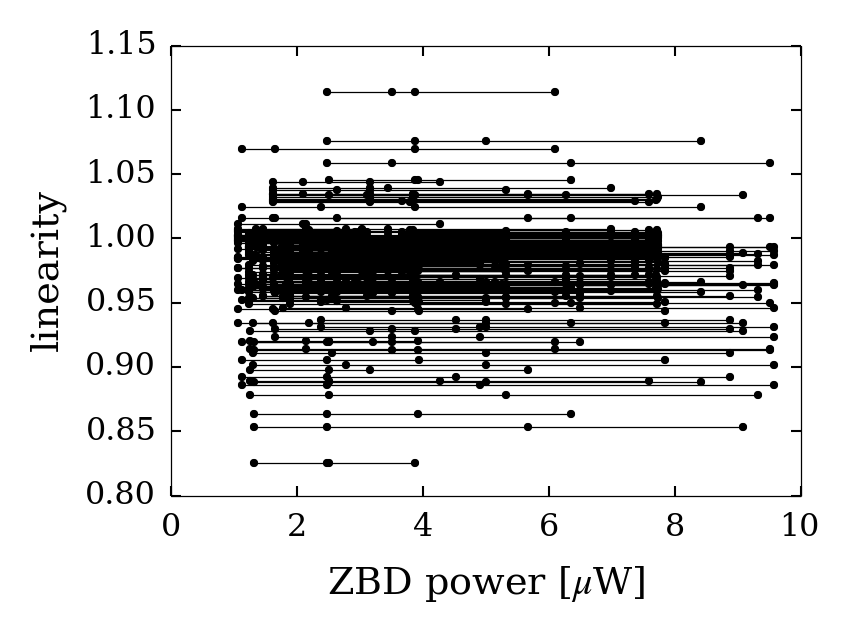

In [130]:
fig, ax = plot_rectangles(linear_rectangles)
ax.set_xlim(0, 10);

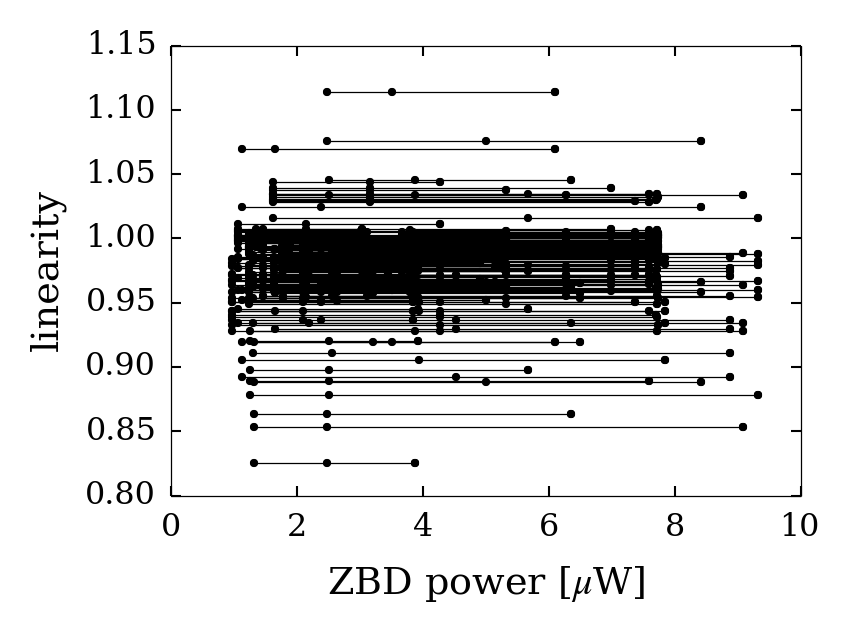

In [129]:
fig, ax = plot_rectangles(linear_rectangles_raw)
ax.set_xlim(0, 10);

In [121]:
HHs = []
HLs = []
LHs = []
LLs = []
linearities = []
for rect in linear_rectangles:
    HHs.append(rect[0])
    HLs.append(rect[1])
    LHs.append(rect[2])
    LLs.append(rect[3])
    linearities.append(rect[4])
HHs = np.array(HHs)
HLs = np.array(HLs)
LHs = np.array(HLs)
LLs = np.array(LLs)
linearities = np.array(linearities)

linearities_raw = np.array([rect[4] for rect in linear_rectangles_raw])

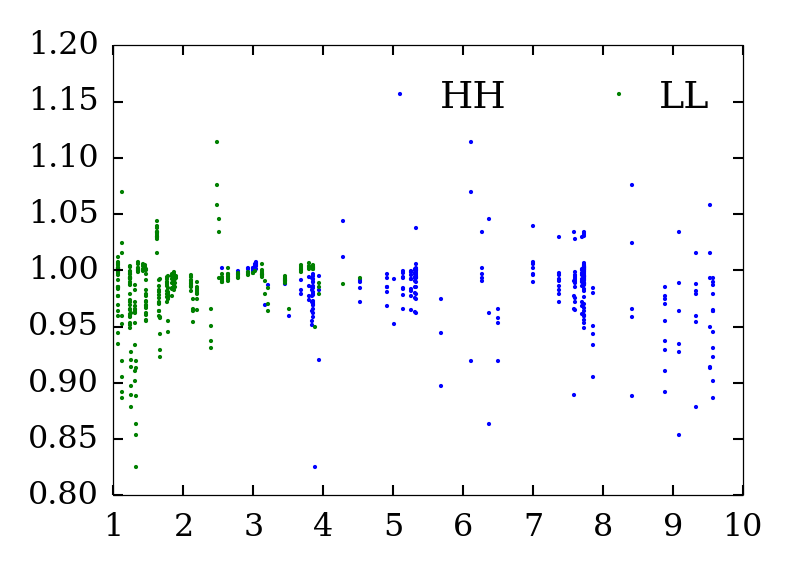

In [122]:
plt.plot(1e6 * HHs, linearities, '.', label='HH', ms=1)
#plt.plot(1e6 * HLs, linearities, '.', label='HL', ms=1)
#plt.plot(1e6 * LHs, linearities, '.', label='LH', ms=1)
plt.plot(1e6 * LLs, linearities, '.', label='LL', ms=1)
plt.ylim(0.80, 1.20)
plt.legend(loc='best', ncol=2)

In [123]:
counts, bins = np.histogram(linearities, bins=40)
counts_raw, bins = np.histogram(linearities_raw, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

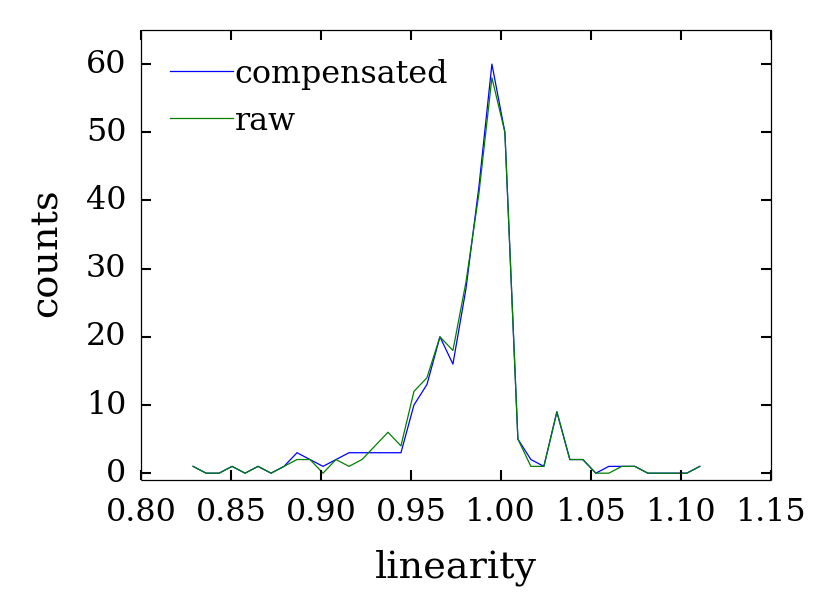

In [127]:
plt.plot(bin_centers, counts, '-', label='compensated')
plt.plot(bin_centers, counts_raw, '-', label='raw')
plt.xlabel('linearity')
plt.ylabel('counts')
plt.legend(loc='best', fontsize='x-small')
plt.ylim(-1, 65);

Conclusion: the compensation doesn't matter much. Use the compensated data.

# Calibrate the uncalibrated points

In [131]:
low_rectangles = []
max1 = 0
max2 = 0
for index, row in df[df.is_low].iterrows():
    for H1 in np.arange(2 * max1, 2 * row.mickey) / 2:
        for H2 in np.arange(2 * max2, 2 * row.minnie) / 2:
                HH, HL, LH, LL = rectangle(df, H1, row.mickey, H2, row.minnie)
                try:
                    if HH.iloc[0].is_linear and HL.iloc[0].is_linear and HL.iloc[0].is_linear:
                        linearity = ((HH.iloc[0].zbd_power * LL.iloc[0].zbd_power) /
                                     (HL.iloc[0].zbd_power * LH.iloc[0].zbd_power))
                        low_rectangles.append((HH.iloc[0].zbd_power,
                                               HL.iloc[0].zbd_power,
                                               LH.iloc[0].zbd_power,
                                               LL.iloc[0].zbd_power,
                                               linearity))
                except IndexError:
                    continue

In [132]:
len(low_rectangles)

340

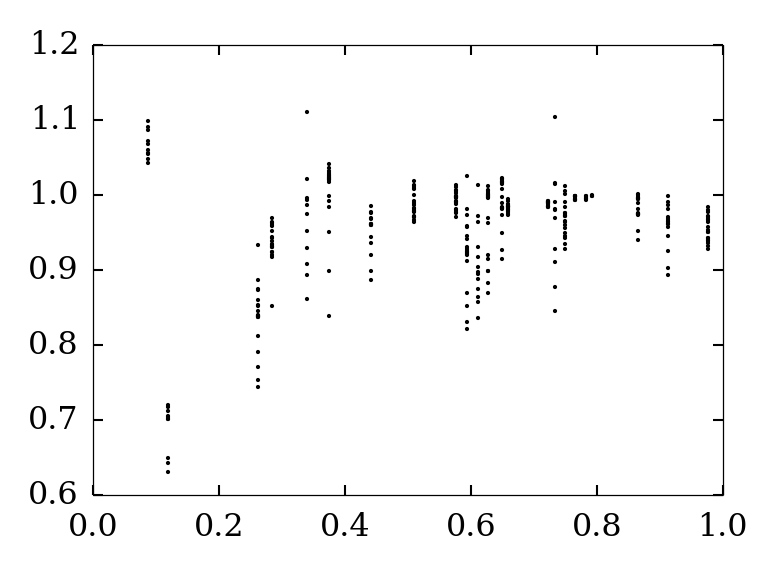

In [133]:
for r in low_rectangles:
    plt.plot(1e6 * r[3], r[4], '.k', ms=1)